In [1]:
### 1 - Reading the moho data (raw) and triangulations
### 2 - Reading / plotting the fitted triangulation
### 3 - Reading / plotting the Fine-grid triangulation

In [2]:
import os.path as path
import stripy as stripy
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import litho1pt0

import gdal


In [3]:
## These are the original data 
mohoraw = np.load("AlaskaMohoErrs.npz")['alaska_moho']
mohorawgrid = stripy.sTriangulation(np.radians(mohoraw['lon']), np.radians(mohoraw['lat']), tree=True, permute=False)

msmoho    = np.load("AlaskaMohoGridded.npz")
mohomodel = stripy.sTriangulation(msmoho['gridlons'], msmoho['gridlats'], tree=True, permute=False)

In [40]:
msmoho_l1pt0 = 0.001 * litho1pt0.layer_depth(lon=np.degrees(msmoho['gridlons']), lat=np.degrees(msmoho['gridlats']), layerID='LID-TOP')

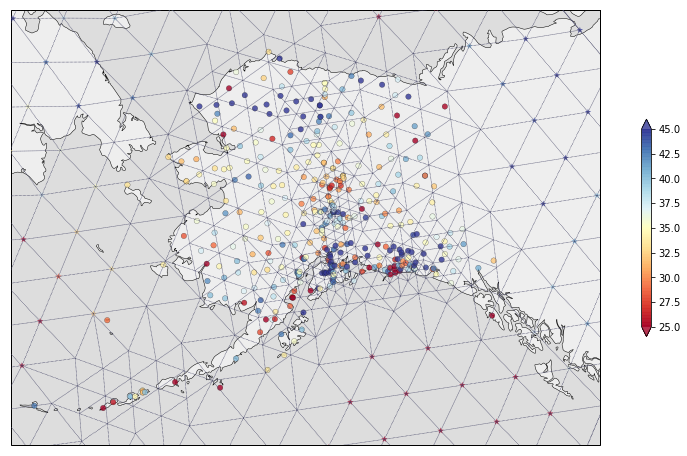

In [51]:
fig = plt.figure(figsize=(15, 8), facecolor=None)

ax  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
ax.set_extent([-175,-130,50,72])
global_extent = [-180,180,-90,90]

grid = mohomodel

ocean = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m", 
                                            name="ocean")

land = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m", 
                                            name="land")


ax.add_feature(ocean, alpha=0.5, zorder=1, facecolor="#DDDDDD")
ax.add_feature(land,  alpha=1.0,  zorder=2, facecolor="#EEEEEE")

ax.coastlines(resolution="50m",color="#000000", linewidth=0.5, zorder=9)

# coloured by moho depth 

m = ax.scatter(mohoraw['lon'], mohoraw['lat'], c=mohoraw['moh'], cmap=plt.cm.RdYlBu,
                edgecolor="Black", linewidth=0.25,
                alpha=0.8, vmin=25, vmax=45,
                marker="o", s=30.0, transform=ccrs.Geodetic(), zorder=10)


lons0 = np.degrees(grid.lons)%360.0
lats0 = np.degrees(grid.lats)

## Triangulation 1 & 2

for tri in grid.simplices: 
    ax.plot( [lons0[tri[0]], lons0[tri[1]], lons0[tri[2]], lons0[tri[0]]],
             [lats0[tri[0]], lats0[tri[1]], lats0[tri[2]], lats0[tri[0]]],
             linewidth=0.5, linestyle=":", 
             color="#444466", transform=ccrs.PlateCarree(), zorder=99 )


cb1 = plt.colorbar(ax=ax, mappable=m, shrink=0.5, extend='both', drawedges=False, alpha=0.0)
# cb1.set_ticks([0.0], update_ticks=True)
# cb1.outline.set_color("White")

unconstrained = np.where(msmoho['quality'] < 1.0e-10)

m2 = ax.scatter(np.degrees(msmoho['gridlons'][unconstrained]), 
                np.degrees(msmoho['gridlats'][unconstrained]), 
                c=msmoho_l1pt0[unconstrained], cmap=plt.cm.RdYlBu,
                edgecolor="Black", linewidth=0.0,
                alpha=0.8, vmin=25, vmax=45,
                marker="*", s=45.0, transform=ccrs.Geodetic(), zorder=10)


In [285]:
## Map everything to a regular triangulation for plotting 

## Define starting grid

grid1r = stripy.spherical_meshes.icosahedral_mesh(include_face_points=False, refinement_levels=8, tree=True)

## Drop points outside the region of interest

angles = grid1r.angular_separation( grid1r.lons, grid1r.lats, np.radians(-158.0) * np.ones_like(grid1r.lons), 
                                   np.radians(62.0) * np.ones_like(grid1r.lats) ) 

nodes = np.where(angles < np.radians(20.0))

lons1 = grid1r.lons[nodes]%(2.0*np.pi)
lats1 = grid1r.lats[nodes]

# identify points within X degrees of a data point

near_nodes, distances = mohorawgrid.nearest_vertex(lons1, lats1) 
nodes = np.where(distances < 0.075)[0]

# # Now identify points within triangles

# i, err = datagrid.interpolate(lons1, lats1, np.ones_like(datagrid.lons))
# nodes = np.where(err==0)

gridF = stripy.sTriangulation(lons1[nodes]%(2.0*np.pi), lats1[nodes], permute=True)

# Use this as a quality measure 

distances_k, near_nodes = mohorawgrid.nearest_vertices(gridF.lons, gridF.lats, k=10) 
distances = distances_k.mean(axis=1)
interpolation_quality_d1 = np.maximum(0.0, 1.0 - 1.0*distances / distances.mean())
interpolation_quality_d2 = np.maximum(0.0, 1.0 - 2.0*distances / distances.mean())


gridF_interpolation, err   = mohomodel.interpolate(gridF.lons, gridF.lats, msmoho['smoothed_data'], order=3)

gridF_ddx, err             = mohomodel.interpolate(gridF.lons, gridF.lats, msmoho['derivatives'][0], order=3)
gridF_ddy, err             = mohomodel.interpolate(gridF.lons, gridF.lats, msmoho['derivatives'][1], order=3)
gridF_ddz, err             = mohomodel.interpolate(gridF.lons, gridF.lats, msmoho['derivatives'][2], order=3)

msmoho_slope =  np.hypot(msmoho['derivatives'][0], msmoho['derivatives'][1], msmoho['derivatives'][2])

gridF_slope, err = mohomodel.interpolate(gridF.lons, gridF.lats, msmoho_slope, order=3)

In [286]:
gridF_l1pt0 = 0.001 * litho1pt0.layer_depth(lon=np.degrees(gridF.lons), lat=np.degrees(gridF.lats), layerID='LID-TOP')

In [287]:
def alaska_moho_plot(filename, grid, data, quality, plot_range=[25.0, 50.0], cmap=None ):
    
    goodgrid = grid
    interpolation_quality = quality
    grid_data = data
    if cmap == None:
        cmap = plt.cm.RdYlBu

    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    ax1.set_extent([-175,-130,50,72])
    ax1.coastlines(resolution="10m",color="#000066", linewidth=0.5, zorder=99)

    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)

    
    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, grid_data, 
                   cmap=cmap, alpha=1.0, 
                   levels=np.linspace(plot_range[0], plot_range[1], 11),
                   extend="max", linewidths=10.0,
                   transform=ccrs.PlateCarree(), zorder=0)
    
    ## Mask by "quality" of the interpolation
    
    cnt1 = ax1.tricontourf(lons, lats, goodgrid.simplices, interpolation_quality, 
                       levels=[ -100, 0.05, 0.1, 0.15, 0.2, 0.25, 1.0],
                       colors=[(1.0,1.0,1.0,1.0), (1.0,1.0,1.0,0.9),
                               (1.0,1.0,1.0,0.8), (1.0,1.0,1.0,0.6),
                               (1.0,1.0,1.0,0.4),(1.0,1.0,1.0,0.2),
                               (1.0,1.0,1.0,0.0)], extend="both",
                       linewidths=0.0,
                       transform=ccrs.PlateCarree(), 
                       zorder=10)  
    
    # This is the fix for the white lines between contour levels
    
    for c in cnt1.collections:
        c.set_edgecolor("#00000000")
        c.set_linewidth(0.0)

    ## Locations of raw data collection

    m = ax1.scatter(mohoraw['lon'], mohoraw['lat'],  color="Black",
                   edgecolor="Black", linewidth=0.5, 
                   marker="+", s=25.0, transform=ccrs.Geodetic(), zorder=25)


    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, extend='max', drawedges=False )

#    print("Saving {}".format(filename))
#     fig.savefig(filename, dpi=600)
#     filename_base, filename_ext = os.path.splitext(filename)

    from PIL import ImageChops
    from PIL import Image
    import io
    
#     im_buffer = io.BytesIO()
#     fig.savefig(im_buffer, format='png', dpi=600)
    
#     im_buffer.seek(0)
#     im = Image.open(im_buffer)
#     im_buffer.close()

#     imbg = Image.open("AlaskaMohoImgBg.png")
#     # im   = Image.open("filename")

#     imblend = ImageChops.multiply(imbg,im)
#     imblend.save("{}+bg.png".format(filename))


 

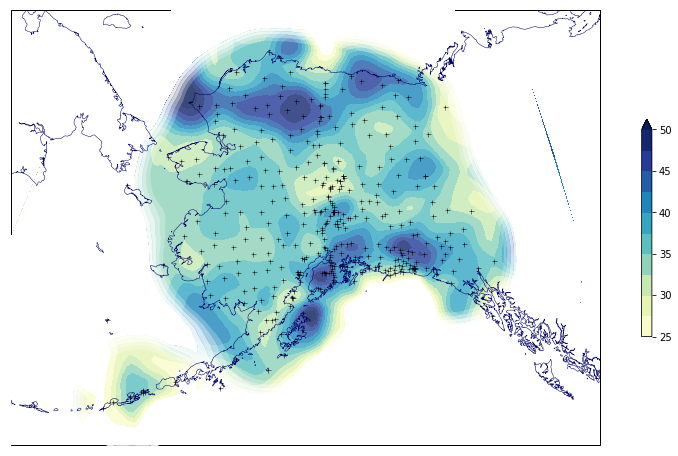

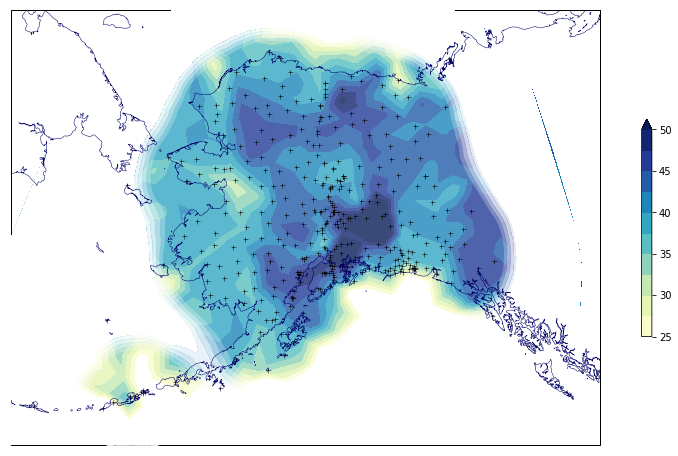

In [288]:
alaska_moho_plot("AlaskaMoho.png", gridF, gridF_interpolation, 
            interpolation_quality_d1, plot_range=[25, 45], cmap=plt.cm.RdYlBu)

alaska_moho_plot("AlaskaMoho_l1pt0.png", gridF, gridF_l1pt0, 
            interpolation_quality_d1, plot_range=[25, 45], cmap=plt.cm.RdYlBu)